In [1]:
import numpy as np
import matplotlib.pyplot as plt

6.663954447385992
6.709113250115015
6.741868727736059
6.762773997271871
6.772366738831602
6.77117404476235
6.759715670421553
6.738506079805508
6.708055583180756
6.668870793809523
6.621454579047406
6.566305642234418
6.503917842265692
6.434779334986977
6.359371602833111
6.278168425148916
6.191634830490942
6.100226063243875
6.004386589612099
5.904549162104385
5.8011339567486555
5.69454779324928
5.585183444974685
5.473419042916242
5.359617575494514
5.24412648422963
5.127277353776726
5.00938569360446
4.890750807622437
4.771655747306173
4.652367343296183
4.533136310034321
4.4141974177234315
4.2957697257356795
4.178056871533136
4.06124740918612
3.945515191666489
3.831019791242734
3.717906952500385
3.606309072745442
3.496345704811982
3.3881240775802324
3.2817396298117476
3.177276553218351
3.0748083409961957
3.0064827589253698
3.0392797573891506
3.0658229316870154
3.086396542654975
3.101272964492068
3.1107157612029583
3.1149818930671764
3.1143232566960695
3.1089877137778967
3.0992197279440563
3

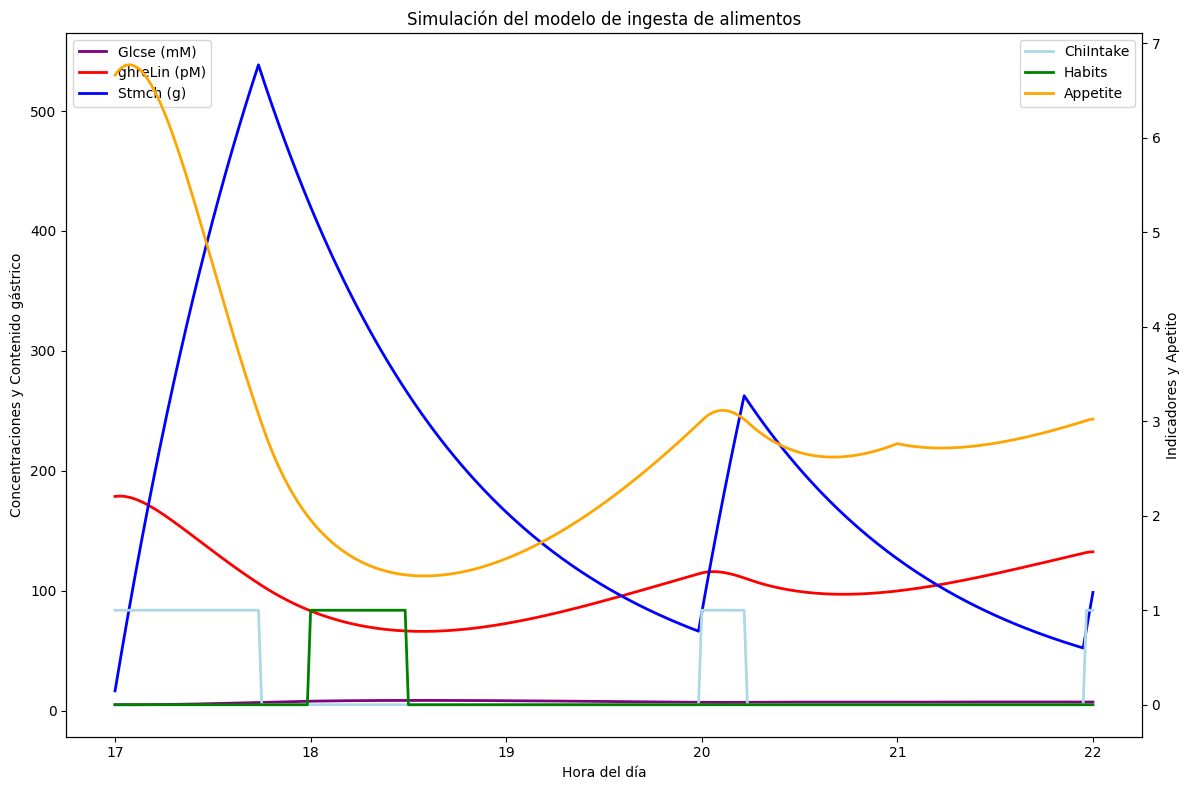

In [ ]:
# Parámetros del modelo

k_max_LS = 4.16       # Tasa máxima de producción de grelina (en pM/min)
lambda_LS = 0.00462   # Tasa de disminución de la secreción de grelina en función del contenido gástrico (1/g)
k_XL = 0.02           # Tasa de eliminación de grelina del torrente sanguíneo (1/min)
k_XG = 0.0072         # Tasa aparente de eliminación de glucosa en condiciones normales (1/min)
k_XGE = 0.0036        # Tasa adicional de eliminación de glucosa durante actividad física (1/min)
k_G = 0.4464          # Tasa constante de entrada de glucosa en plasma desde el hígado (mmol/min)
rho_GS = 0.9          # Fracción de glucosa en los alimentos que es realmente absorbida por el intestino
eta_G = 0.2           # Contribución de los alimentos al nivel de glucosa en sangre (g glucosa/g alimento)
V_G = 12.4            # Volumen de distribución de la glucosa en el cuerpo (litros)
A_max = 50            # Valor máximo de apetito en unidades arbitrarias
L_A50 = 120           # Concentración de grelina en plasma cuando el apetito alcanza el 50% de su máximo (pM)
lambda_AG = 0.3       # Factor que representa la reducción del apetito debido a un aumento en la glucosa (1/mM)
k_XS = 0.0154         # Tasa de vaciamiento gástrico (1/min)
k_S = 16.5            # Tasa de ingesta de alimentos cuando la persona está comiendo (g/min)
S_50 = 150            # Contenido gástrico al cual la secreción de grelina se reduce al 50% de su máximo (g)
L_ss = 178            # Nivel de grelina en estado estable durante el ayuno (pM)
G_ss = 5              # Concentración de glucosa en estado estable en condiciones normales (mM)


# Configuración de simulación
t_start = 17 * 60                # Inicio del día (0:00)
t_end = 22 * 60            # Fin del día (24:00)
dt = 1                     # Intervalo de tiempo (minutos)
time = np.arange(t_start, t_end + dt, dt)

# Límites de actividad física
E_T_L = 300  # Inicio de actividad física a las 18:00
# E_T_L = 0 * 60  # Inicio de actividad física a las 18:00
E_T_U = 1260  # Fin de actividad física a las 19:00
# E_T_U = 24 * 60  # Fin de actividad física a las 19:00


# Simulación
nervous_time = 15  # Nerviosismo comienza en el minuto 15
euphoric_time = 40  # Euforia comienza en el minuto 40
walking_start = 0  # Comienza a caminar en el minuto 5


# Horarios de comida (Habits)
meal_times = [8 * 60, 13 * 60, 18 * 60]  # Desayuno, almuerzo y cena
meal_duration = 30  # Duración de cada comida (minutos)

# Función para actividad física
def physical_activity(t):
    if (t % 1440) >= E_T_L and (t % 1440) < E_T_U:
        return 1
    return 0

# Función para hábitos alimenticios
def habits(t):
    for meal_time in meal_times:
        if meal_time <= (t % 1440) < (meal_time + meal_duration):
            return 1
   
    return 0

# Variables iniciales

S = 0              # Contenido inicial del estómago (gramos). 
                   # Asume que al inicio no hay alimentos en el estómago (persona en ayuno).

L = L_ss           # Concentración inicial de grelina plasmática (pM).
                   # Se toma el valor en estado estable (\( L_{\text{ss}} \)), correspondiente a condiciones de ayuno.

G = G_ss           # Concentración inicial de glucosa plasmática (mM).
                   # Se establece en el valor en estado estable (\( G_{\text{ss}} \)), típico de condiciones normales en ayuno.

A = 0              # Nivel inicial de apetito (unidades arbitrarias).
                   # Asume que el apetito inicial es nulo, posiblemente porque no se ha alcanzado un estímulo para comer.

chi_intake = 0     # Indicador inicial de ingesta de alimentos (0 o 1).
                   # Inicialmente no se está comiendo (\( \chi_{\text{intake}} = 0 \)).

# Variables para almacenar resultados
S_vals, L_vals, G_vals, A_vals, E_vals, H_vals, Chi_vals = [], [], [], [], [], [], []

# Parámetros adicionales
effect_nervousness = -0.2  # Reducción porcentual del apetito por nerviosismo
effect_euphoria = 0.3     # Incremento porcentual del apetito por euforia
walking_duration = 10     # Duración de caminar tres cuadras (minutos)
emotion_duration = 30     # Duración de efectos emocionales (minutos)
initial_state = np.random.choice(['fed', 'fasting'])  # Estado inicial


S = 200 if initial_state == 'fed' else 0  # Comió o no al inicio


# Funciones de emociones
def emotional_effect(t, nervous_time, euphoric_time):
    """Modela el impacto emocional en el apetito."""
    if nervous_time <= t < nervous_time + emotion_duration:
        return 1 + effect_nervousness
    elif euphoric_time <= t < euphoric_time + emotion_duration:
        return 1 + effect_euphoria
    return 0  # Sin impacto emocional

# Función para caminar
def walking_effect(t, walking_start, walking_duration):
    """Impacto de caminar en los niveles de glucosa y grelina."""
    if walking_start <= t < walking_start + walking_duration:
        return 0.2  # Incremento en eliminación de glucosa
    return 0


# Simulación (se calcula previamente y luego el hincha actua por cada t)
for t in time:
    # Indicadores

    emotion_factor = emotional_effect(t, nervous_time, euphoric_time)
    walking_factor = walking_effect(t, walking_start, walking_duration)

    E = physical_activity(t)  # Actividad física
    H = habits(t)             # Hábitos alimenticios

    # Apetito
    A = A_max * (L / (L_A50 + L)) * np.exp(-lambda_AG * G)

    # Estado de ingesta
    if  (A >= 3):
        chi_intake = 1
        print(A)
    else:
        chi_intake = 0 
        

    # chi_intake = 1 if H or (A >= 2) else 0  # Se come si hay hábito o el apetito es alto



    # Grelina
    dL = k_max_LS * np.exp(-lambda_LS * S) - k_XL * L
    L += dL * dt

    # Glucosa
    dG = -(k_XG + k_XGE * E) * G + (k_G + k_XS * eta_G * rho_GS * S) / V_G
    G += dG * dt

    # Contenido gástrico
    dS = -k_XS * S + k_S * chi_intake
    S += dS * dt
    S = max(S, 0)

    # Guardar resultados
    S_vals.append(S)
    L_vals.append(L)
    G_vals.append(G)
    A_vals.append(A)
    E_vals.append(E)
    H_vals.append(H)
    Chi_vals.append(chi_intake)

# Gráficas
fig, ax1 = plt.subplots(figsize=(12, 8))

# Primer gráfico (Glucosa, Grelina, Contenido gástrico)
ax1.plot(time / 60, G_vals, label="Glcse (mM)", color="purple", linewidth=2)
ax1.plot(time / 60, L_vals, label="ghreLin (pM)", color="red", linewidth=2)
ax1.plot(time / 60, S_vals, label="Stmch (g)", color="blue", linewidth=2)
ax1.set_ylabel("Concentraciones y Contenido gástrico")
ax1.set_xlabel("Hora del día")
ax1.legend(loc="upper left")

# Segundo gráfico (ChiIntake, Habits, Appetite)
ax2 = ax1.twinx()
ax2.plot(time / 60, Chi_vals, label="ChiIntake", color="lightblue", linewidth=2)
ax2.plot(time / 60, H_vals, label="Habits", color="green", linewidth=2)
ax2.plot(time / 60, A_vals, label="Appetite", color="orange", linewidth=2)
ax2.set_ylabel("Indicadores y Apetito")
ax2.legend(loc="upper right")

plt.title("Simulación del modelo de ingesta de alimentos")
plt.tight_layout()
plt.show()



